# How to work with ERA5 Essential Climate Variables on Earth Data Hub
### Climatological analysis of temperature in Germany

***
This notebook will provide you guidance on how to access and use the `ecv-for-climate-change-1979-2023.zarr` datset on Earth Data Hub.

The first goal is to compute the 2 metre temperature anomaly in Winter 2022 over Central Europe.

The second goal is show the winter anomaly trend, for the available time period, by averaging the anomaly over the selected area.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [2]:
import xarray as xr

ds = xr.open_dataset(
    "https://edh:edh_pat_23a2b81aefcdb2ae1069d181fb3d026da9dc473ff3652113219e96b681bc3aff9c503025c5d952a71a3e15c23251e913@data.earthdatahub.destine.eu/more-era5/ecv-for-climate-change-1981-2010-anomaly-v0",
    storage_options={"client_kwargs":{"trust_env":True}},
    chunks={},
    engine="zarr",
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (latitude: 721, longitude: 1440, time: 547)
Coordinates:
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-07-01
    valid_time  (time) datetime64[ns] 4kB dask.array<chunksize=(120,), meta=np.ndarray>
Data variables:
    t2m         (time, latitude, longitude) float32 2GB dask.array<chunksize=(120, 256, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-08-20T17:30 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## 2 metre temperature: central Europe winter 2022 anomaly

### 1. Data selection

First, we select the 2 metre temperature anomaly from the ECV dataset. Then, we perform a geographical selection corresponding to the central Europe area. This greatly reduces the amount of data that will be downloaded from EDH.

In [3]:
t2m_anomaly = ds.t2m
t2m_anomaly_central_europe = t2m_anomaly.sel(**{"latitude": slice(55, 45), "longitude": slice(2, 24)})
t2m_anomaly_central_europe

<xarray.DataArray 't2m' (time: 547, latitude: 41, longitude: 89)> Size: 8MB
dask.array<getitem, shape=(547, 41, 89), dtype=float32, chunksize=(120, 41, 89), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 328B 55.0 54.75 54.5 ... 45.5 45.25 45.0
  * longitude   (longitude) float64 712B 2.0 2.25 2.5 2.75 ... 23.5 23.75 24.0
    number      int64 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * time        (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-07-01
    valid_time  (time) datetime64[ns] 4kB dask.array<chunksize=(120,), meta=np.ndarray>
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

At this point, no data has been downloaded yet, nor loaded in memory. However, the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [4]:
%%time

t2m_anomaly_central_europe = t2m_anomaly_central_europe.compute()

CPU times: user 734 ms, sys: 662 ms, total: 1.4 s
Wall time: 1.33 s


The selection was small, this didn't take long!

### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the average 2 metre temperature anomaly by season:

In [5]:
t2m_anomaly_central_europe_seasonal_mean = t2m_anomaly_central_europe.resample(time="QS-DEC").mean(dim="time")

And the winter 2022 anomaly:

In [6]:
t2m_anomaly_central_europe_winter_2022_mean = t2m_anomaly_central_europe_seasonal_mean.sel(time=f"2022-{12}")

### 3. Visualization

We can plot the average winter 2022 anomaly on a map:

/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


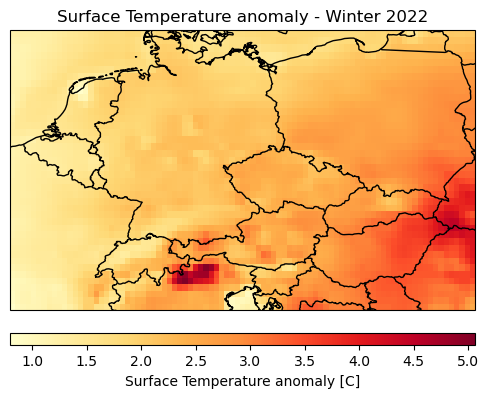

In [7]:
from cartopy import crs, feature
import matplotlib.pyplot as plt

_, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw={"projection": crs.Miller()},
)
t2m_anomaly_central_europe_winter_2022_mean.plot(
    ax=ax, 
    cmap="YlOrRd", 
    transform=crs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Surface Temperature anomaly [C]"},
)
ax.coastlines()
ax.add_feature(feature.BORDERS)
ax.set_title("Surface Temperature anomaly - Winter 2022")
plt.show()

## 2 metre temperature: central Europe winter anomaly trend (spatial mean)

We want to compute the average 2 metre temperature anomaly trend over Central Europe in winter. We already have `t2m_anomaly_central_europe` loaded in memory, we average it by seson and region:

In [8]:
t2m_anomaly_central_europe_seasonal_and_spatial_mean = t2m_anomaly_central_europe.resample(time="QS-DEC").mean(dim=["time", "latitude", "longitude"])
t2m_anomaly_central_europe_seasonal_and_spatial_mean

<xarray.DataArray 't2m' (time: 183)> Size: 732B
array([-2.9028668 , -0.91686445, -1.1011523 , -0.62883353, -0.02496469,
       -2.1457644 , -1.5287069 , -0.79523385, -1.1790578 ,  0.26501378,
       -0.8942913 , -0.08368923, -1.8071241 , -0.86565965,  0.05411975,
        1.1065823 ,  0.8149916 ,  0.09785875,  0.55486375, -0.3492933 ,
       -0.25422293, -1.5726587 , -1.5584178 ,  0.19027324, -3.4835947 ,
       -0.69563466, -1.1934365 , -1.0984583 , -1.425193  , -0.50244397,
       -0.744212  , -0.20632517, -2.3080893 , -2.4561915 , -1.2855451 ,
        0.5774903 ,  1.6169659 , -0.4335804 , -0.4710706 , -0.8911479 ,
        1.9133197 ,  0.8433306 , -0.5130848 ,  0.0317968 ,  2.441855  ,
        0.93721026, -0.49025655, -0.2411563 , -0.95673835, -0.9762092 ,
       -0.33167768, -0.06303002,  0.1857863 ,  0.1749869 ,  1.0761096 ,
       -0.60613203,  0.01011974,  0.4413533 , -1.0041068 , -1.8658202 ,
        1.250837  ,  0.38671318,  1.0382583 ,  0.42149854,  1.8016574 ,
       -0.52073044,  0.35329348, -0.1862578 , -2.5135026 , -1.3701468 ,
       -0.7570198 , -0.54604197, -0.8338568 , -0.4674673 ,  0.17572695,
       -0.41899237,  2.0582275 ,  0.369274  , -0.23973441, -1.2645695 ,
       -0.05273637,  0.7368295 ,  0.21249998,  0.45978853,  1.0066284 ,
        1.3682635 , -0.21537818,  1.2450855 ,  1.4238845 ,  0.26339453,
        0.13901275,  0.08345842,  0.7155556 ,  0.97033745,  0.9506548 ,
        0.14853084, -1.6331441 ,  0.6366805 ,  2.2059827 , -0.23701918,
        0.22506317, -0.25492063, -0.13320053,  0.55619514, -0.06661345,
       -0.19667514, -0.17203012,  0.8303849 , -1.5108515 , -0.67635673,
        0.9139839 ,  2.483585  ,  3.3157732 ,  2.073838  ,  0.5671766 ,
       -0.8324704 ,  1.9156709 ,  0.4708178 ,  0.46107778,  0.17343107,
       -0.30008125,  1.2177347 ,  0.42837387,  1.0413847 , -1.4412302 ,
       -0.2652198 ,  0.8721116 , -0.45926437, -1.1831658 ,  1.3592219 ,
        0.15660578,  0.70297486, -0.0546115 ,  1.1443378 ,  0.72099656,
        0.7271136 , -0.4144543 , -1.203885  ,  0.789326  ,  0.7027451 ,
        2.363584  ,  1.5757308 ,  0.21123204,  1.8451912 ,  1.4435743 ,
        0.47616556,  1.5518341 ,  0.71888566,  2.6405146 ,  0.47644308,
        0.7526437 ,  0.5618266 ,  0.01820651,  1.1516002 ,  1.1977515 ,
        0.51907676,  0.85502315,  1.6053462 ,  2.0048032 ,  1.5459603 ,
        1.6765939 ,  0.7102029 ,  2.168115  ,  1.4837991 ,  3.2487154 ,
        0.71864885,  1.0826571 ,  1.4123821 ,  1.2607342 , -1.0772437 ,
        1.1628449 ,  0.73247844,  2.0350213 ,  0.4765324 ,  2.1940374 ,
        1.4819975 ,  2.270644  ,  0.40186033,  1.5116358 ,  2.5283012 ,
        3.2001677 ,  2.256315  ,  1.5856096 ], dtype=float32)
Coordinates:
    number   int64 8B 0
    step     timedelta64[ns] 8B 00:00:00
    surface  float64 8B 0.0
  * time     (time) datetime64[ns] 1kB 1978-12-01 1979-03-01 ... 2024-06-01
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    GRIB_uvRelativeToGrid:                    0
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

Next, we select only the winter values:

In [9]:
t2m_anomaly_central_europe_winter_spatial_mean = t2m_anomaly_central_europe_seasonal_and_spatial_mean.sel(time=t2m_anomaly_central_europe_seasonal_and_spatial_mean["time.month"] == int(12))

We can plot the result:

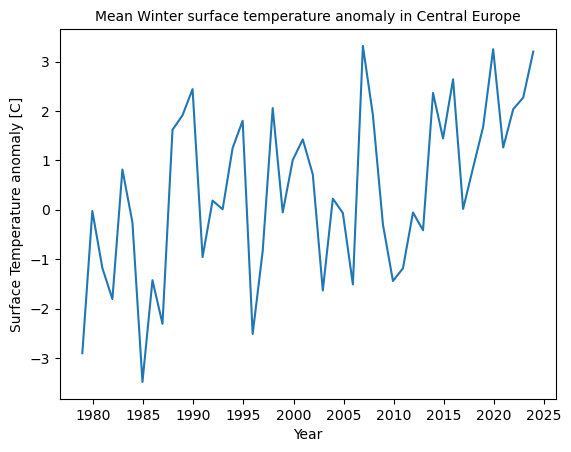

In [10]:
plt.plot(t2m_anomaly_central_europe_winter_spatial_mean["time"], t2m_anomaly_central_europe_winter_spatial_mean)
plt.xlabel("Year")
plt.ylabel("Surface Temperature anomaly [C]")
plt.title("Mean Winter surface temperature anomaly in Central Europe", size=10)
plt.show()

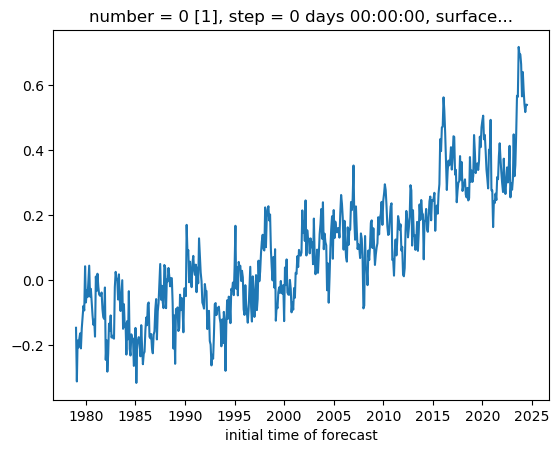

In [14]:
import numpy as np

(t2m_anomaly * np.cos(np.deg2rad(t2m_anomaly.latitude))).mean(["latitude", "longitude"]).plot()